In [83]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize
import os

In [84]:
model_path = '../runs/RNN/Without_Aug/'
midi_sequences = model_path + 'outputs/midi_sequences.txt'

In [85]:
# Example MIDI data
midi_data_sets = []

# midi_sequences.txt of format: [[note,duration,gap], [note,duration,gap], ...]
with open(midi_sequences, 'r') as f:
    for line in f:
        midi_data = {'pitches': [], 'durations': [], 'gaps': []}
        for note in line.strip().split('], ['):
            note = note.strip('[]')
            note = note.split(',')
            midi_data['pitches'].append(int(note[0]))
            midi_data['durations'].append(float(note[1]))
            midi_data['gaps'].append(float(note[2]))
        midi_data_sets.append(midi_data)

# Calculate start times based on durations and gaps
for midi_data in midi_data_sets:
    start_times = [0]  # initial start time
    for i in range(1, len(midi_data['pitches'])):
        next_start = start_times[i-1] + midi_data['durations'][i-1] + midi_data['gaps'][i]
        start_times.append(next_start)
    midi_data['start_times'] = start_times


In [86]:
len(midi_data_sets)

10

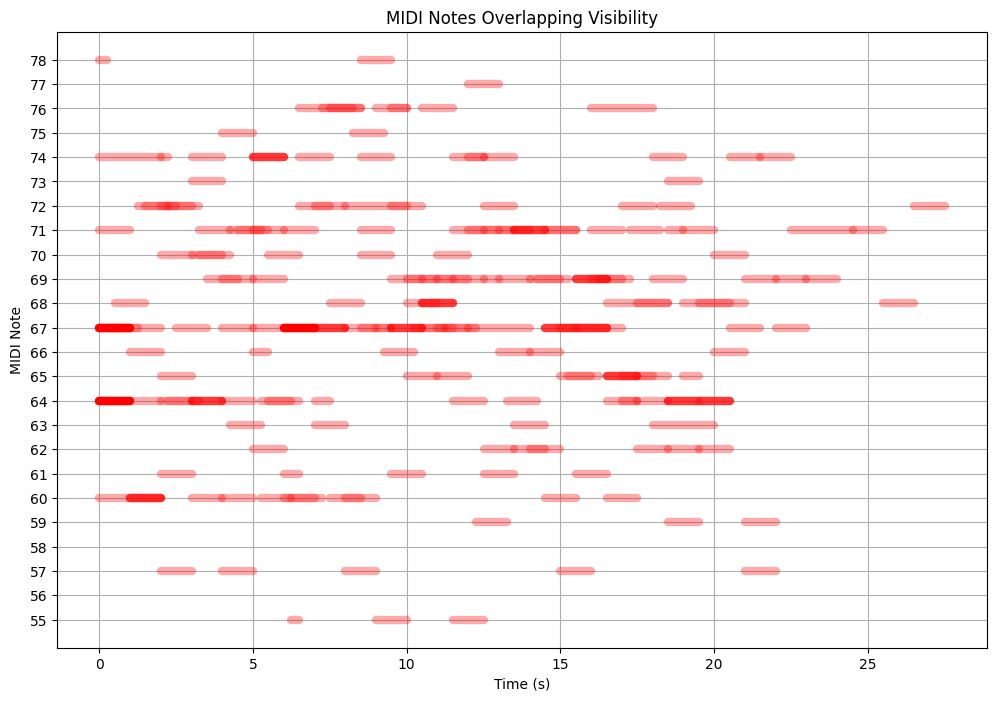

In [87]:
from collections import defaultdict

# Calculate the actual count of overlaps for each note
note_count = defaultdict(int)
for midi_data in midi_data_sets:
    start_times = midi_data['start_times']
    for pitch, start in zip(midi_data['pitches'], start_times):
        note_count[(start, pitch)] += 1

# Now calculate the maximum possible opacity increment based on the highest overlap
max_overlap = max(note_count.values())
opacity_increment = 1 / max_overlap

# Initialize plotting lists
segments = []
colors = []
opacity_tracker = {}

# Generate segments and calculate opacity
for midi_data in midi_data_sets:
    start_times = midi_data['start_times']
    for pitch, start, duration in zip(midi_data['pitches'], start_times, midi_data['durations']):
        line = [(start, pitch), (start + duration, pitch)]
        segments.append(line)
        if (start, pitch) not in opacity_tracker:
            opacity_tracker[(start, pitch)] = opacity_increment  # Initial opacity
        else:
            opacity_tracker[(start, pitch)] = min(opacity_tracker[(start, pitch)] + opacity_increment, 1)  # Prevent exceeding full opacity
        
        colors.append((1, 0, 0, opacity_tracker[(start, pitch)]))  # Red with calculated alpha

# Plotting
plt.figure(figsize=(12, 8))
lc = LineCollection(segments, colors=colors, linewidths=6, capstyle='round')
plt.gca().add_collection(lc)
plt.xlabel('Time (s)')
plt.ylabel('MIDI Note')
plt.title('MIDI Notes Overlapping Visibility')
plt.grid(True)
plt.yticks(range(min(min(midi['pitches']) for midi in midi_data_sets), max(max(midi['pitches']) for midi in midi_data_sets)+1))
plt.autoscale()
plt.show()

